In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json

import torch
import torch.nn as nn
import torch.optim as optim

import optuna

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc,matthews_corrcoef, precision_recall_curve,roc_auc_score



データ読み取り

In [2]:
df=pd.read_csv('learning_data.csv',index_col=0)

X=df.drop(columns='dengue',axis=1).values
y=df['dengue'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1,random_state=0)

#torchテンソルに変換
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)


In [3]:
class DNN_3(nn.Module):
    def __init__(self, input_dim,dropout1,dropout2):
        super(DNN_3, self).__init__()
        self.layer1 = nn.Linear(input_dim,32)
        self.layer2 = nn.Linear(32,16)
        self.layer3 = nn.Linear(16, 8)
        self.layer4 = nn.Linear(8, 4)
        self.output_layer = nn.Linear(4, 1)

        self.bn1=nn.BatchNorm1d(32)
        self.bn2=nn.BatchNorm1d(16)
        self.bn3=nn.BatchNorm1d(8)
        self.bn4=nn.BatchNorm1d(4)

        self.dropout1 = nn.Dropout(dropout1)
        self.dropout2 = nn.Dropout(dropout2)        
        
    def forward(self, x):
        x = torch.relu(self.bn1(self.layer1(x)))
        
        x = torch.relu(self.bn2(self.layer2(x)))
        x = self.dropout1(x)

        x = torch.relu(self.bn3(self.layer3(x)))
        x = self.dropout2(x)

        x = torch.relu(self.bn4(self.layer4(x)))
    

        x = torch.sigmoid(self.output_layer(x)) 
        return x
    

学習データセットの作成

In [4]:
train_dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=128, shuffle=True)

val_dataset = torch.utils.data.TensorDataset(X_val_tensor, y_val_tensor)
val_loader = torch.utils.data.DataLoader(dataset=val_dataset, batch_size=128, shuffle=False)

Optunaの設定

In [5]:
def objective(trial):
    # ハイパーパラメータのサンプリング
    dropout1 = trial.suggest_float("dropout1", 0, 0.5, step=0.05)
    dropout2 = trial.suggest_float("dropout2", 0, 0.5, step=0.05)
    learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)  
    weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)   

    # モデル定義
    model = DNN_3(
        input_dim=X_train_tensor.shape[1],
        dropout1=dropout1,
        dropout2=dropout2,
    ).to(device)

    criterion = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    # Early Stoppingの設定
    patience = 10
    best_val_loss = float('inf')
    patience_counter = 0

    # 訓練ループ
    num_epochs = 100
    for epoch in range(num_epochs):
        model.train()
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            outputs = model(X_batch).squeeze()
            loss = criterion(outputs, y_batch.squeeze())
            loss.backward()
            optimizer.step()

        # バリデーション評価
        model.eval()
        val_loss = 0
        val_true, val_pred = [], []
        with torch.no_grad():
            for X_val, y_val in val_loader:
                X_val, y_val = X_val.to(device), y_val.to(device)
                val_outputs = model(X_val).squeeze()
                val_loss += criterion(val_outputs, y_val.squeeze()).item()
                predictions = (val_outputs >=0.5).float()
                val_true.extend(y_val.cpu().numpy())
                val_pred.extend(predictions.cpu().numpy())

        val_loss /= len(val_loader)

        # Early Stopping判定
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch}")
            break

        # Optunaへのログ
        trial.report(val_loss, epoch)
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    # 最終的な評価指標を計算
    mcc = matthews_corrcoef(val_true, val_pred)
    print(f"Final MCC: {mcc:.4f}")

    return mcc  # mccを返す


In [6]:
device_id = 0  # 使用するGPUのID（0または1）
torch.cuda.set_device(device_id)
device = torch.device(f"cuda:{device_id}" if torch.cuda.is_available() else "cpu")

# Optunaの設定
study = optuna.create_study(direction="maximize")  
study.optimize(objective, n_trials=100)

# 結果表示
print("Best Parameters: ", study.best_params)
print("Best Validation F1: ", study.best_value)

[I 2024-12-18 13:39:23,924] A new study created in memory with name: no-name-e6089978-745d-4e4d-b264-c8977de91625
/tmp/ipykernel_41780/2951396850.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
/tmp/ipykernel_41780/2951396850.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)
[I 2024-12-18 13:39:38,327] Trial 0 finished with value: 0.06806680596826645 and parameters: {'dropout1': 0.30000000000000004, 'dropout2': 0.35000000000000003, 'learning_rate': 0.0001367128138114678, 'weight_decay': 0.006649635874385469}. Best is trial 0 wit

Final MCC: 0.0681


/tmp/ipykernel_41780/2951396850.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
/tmp/ipykernel_41780/2951396850.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)
[I 2024-12-18 13:39:51,336] Trial 1 finished with value: 0.05284595647100759 and parameters: {'dropout1': 0.15000000000000002, 'dropout2': 0.0, 'learning_rate': 2.219041490057751e-05, 'weight_decay': 1.4388352793955315e-05}. Best is trial 0 with value: 0.06806680596826645.


Final MCC: 0.0528


/tmp/ipykernel_41780/2951396850.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
/tmp/ipykernel_41780/2951396850.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)
[I 2024-12-18 13:40:04,871] Trial 2 finished with value: 0.3234205966366991 and parameters: {'dropout1': 0.05, 'dropout2': 0.5, 'learning_rate': 5.063460200182974e-05, 'weight_decay': 2.384972025250731e-05}. Best is trial 2 with value: 0.3234205966366991.


Final MCC: 0.3234


/tmp/ipykernel_41780/2951396850.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
/tmp/ipykernel_41780/2951396850.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)
[I 2024-12-18 13:40:17,634] Trial 3 finished with value: 0.32112745509435936 and parameters: {'dropout1': 0.35000000000000003, 'dropout2': 0.15000000000000002, 'learning_rate': 1.398611648174477e-05, 'weight_decay': 0.00759973315561456}. Best is trial 2 with value: 0.3234205966366991.


Final MCC: 0.3211


/tmp/ipykernel_41780/2951396850.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
/tmp/ipykernel_41780/2951396850.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)
[I 2024-12-18 13:40:19,627] Trial 4 finished with value: 0.22349433867098178 and parameters: {'dropout1': 0.05, 'dropout2': 0.1, 'learning_rate': 0.005488214068535487, 'weight_decay': 1.0902051518798332e-05}. Best is trial 2 with value: 0.3234205966366991.
/tmp/ipykernel_41780/2951396850.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature

Early stopping at epoch 15
Final MCC: 0.2235


[I 2024-12-18 13:40:32,441] Trial 6 finished with value: 0.37634522748244265 and parameters: {'dropout1': 0.0, 'dropout2': 0.4, 'learning_rate': 5.9871604609319157e-05, 'weight_decay': 5.5644814477398304e-05}. Best is trial 6 with value: 0.37634522748244265.
/tmp/ipykernel_41780/2951396850.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
/tmp/ipykernel_41780/2951396850.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)
[I 2024-12-18 13:40:32,592] Trial 7 pruned. 


Final MCC: 0.3763


[I 2024-12-18 13:40:32,728] Trial 8 pruned. 
[I 2024-12-18 13:40:32,848] Trial 9 pruned. 
[I 2024-12-18 13:40:33,006] Trial 10 pruned. 
[I 2024-12-18 13:40:33,136] Trial 11 pruned. 
[I 2024-12-18 13:40:41,330] Trial 12 finished with value: 0.293770671583485 and parameters: {'dropout1': 0.0, 'dropout2': 0.4, 'learning_rate': 0.0003615514003259888, 'weight_decay': 0.00011620332116411021}. Best is trial 6 with value: 0.37634522748244265.
/tmp/ipykernel_41780/2951396850.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
/tmp/ipykernel_41780/2951396850.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  w

Early stopping at epoch 64
Final MCC: 0.2938


[I 2024-12-18 13:40:41,663] Trial 14 pruned. 
[I 2024-12-18 13:40:41,813] Trial 15 pruned. 
[I 2024-12-18 13:40:41,976] Trial 16 pruned. 
[I 2024-12-18 13:40:42,135] Trial 17 pruned. 
[I 2024-12-18 13:40:42,287] Trial 18 pruned. 
[I 2024-12-18 13:40:42,460] Trial 19 pruned. 
[I 2024-12-18 13:40:55,499] Trial 20 finished with value: 0.3067824844174605 and parameters: {'dropout1': 0.05, 'dropout2': 0.4, 'learning_rate': 8.44837031842906e-05, 'weight_decay': 7.310644135495665e-05}. Best is trial 6 with value: 0.37634522748244265.
/tmp/ipykernel_41780/2951396850.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
/tmp/ipykernel_41780/2951396850.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https

Final MCC: 0.3068


[I 2024-12-18 13:40:55,828] Trial 22 pruned. 
[I 2024-12-18 13:40:55,994] Trial 23 pruned. 
[I 2024-12-18 13:40:56,161] Trial 24 pruned. 
[I 2024-12-18 13:40:56,338] Trial 25 pruned. 
[I 2024-12-18 13:40:56,513] Trial 26 pruned. 
[I 2024-12-18 13:40:56,677] Trial 27 pruned. 
[I 2024-12-18 13:40:56,840] Trial 28 pruned. 
[I 2024-12-18 13:40:57,011] Trial 29 pruned. 
[I 2024-12-18 13:40:57,186] Trial 30 pruned. 
[I 2024-12-18 13:40:57,351] Trial 31 pruned. 
[I 2024-12-18 13:40:57,526] Trial 32 pruned. 
[I 2024-12-18 13:40:57,698] Trial 33 pruned. 
[I 2024-12-18 13:41:10,316] Trial 34 finished with value: 0.3646372606420278 and parameters: {'dropout1': 0.05, 'dropout2': 0.5, 'learning_rate': 6.293200936776195e-05, 'weight_decay': 7.636806188318224e-05}. Best is trial 6 with value: 0.37634522748244265.
/tmp/ipykernel_41780/2951396850.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/t

Final MCC: 0.3646


[I 2024-12-18 13:41:10,627] Trial 36 pruned. 
[I 2024-12-18 13:41:10,756] Trial 37 pruned. 
[I 2024-12-18 13:41:10,913] Trial 38 pruned. 
[I 2024-12-18 13:41:11,068] Trial 39 pruned. 
[I 2024-12-18 13:41:11,245] Trial 40 pruned. 
[I 2024-12-18 13:41:11,410] Trial 41 pruned. 
[I 2024-12-18 13:41:11,569] Trial 42 pruned. 
[I 2024-12-18 13:41:11,728] Trial 43 pruned. 
[I 2024-12-18 13:41:11,884] Trial 44 pruned. 
[I 2024-12-18 13:41:12,043] Trial 45 pruned. 
[I 2024-12-18 13:41:12,215] Trial 46 pruned. 
[I 2024-12-18 13:41:12,378] Trial 47 pruned. 
[I 2024-12-18 13:41:12,525] Trial 48 pruned. 
[I 2024-12-18 13:41:12,702] Trial 49 pruned. 
[I 2024-12-18 13:41:12,866] Trial 50 pruned. 
[I 2024-12-18 13:41:13,026] Trial 51 pruned. 
[I 2024-12-18 13:41:13,190] Trial 52 pruned. 
[I 2024-12-18 13:41:13,320] Trial 53 pruned. 
[I 2024-12-18 13:41:13,479] Trial 54 pruned. 
[I 2024-12-18 13:41:13,634] Trial 55 pruned. 
[I 2024-12-18 13:41:13,767] Trial 56 pruned. 
[I 2024-12-18 13:41:13,935] Trial 

Final MCC: 0.4115


[I 2024-12-18 13:41:29,300] Trial 73 pruned. 
[I 2024-12-18 13:41:29,473] Trial 74 pruned. 
[I 2024-12-18 13:41:29,630] Trial 75 pruned. 
[I 2024-12-18 13:41:31,070] Trial 76 finished with value: 0.0 and parameters: {'dropout1': 0.35000000000000003, 'dropout2': 0.15000000000000002, 'learning_rate': 1.1497955302100407e-05, 'weight_decay': 0.0027743037384799717}. Best is trial 71 with value: 0.4114760291332042.
/tmp/ipykernel_41780/2951396850.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
/tmp/ipykernel_41780/2951396850.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.sugges

Early stopping at epoch 10
Final MCC: 0.0000


[I 2024-12-18 13:41:31,388] Trial 78 pruned. 
[I 2024-12-18 13:41:31,555] Trial 79 pruned. 
[I 2024-12-18 13:41:31,735] Trial 80 pruned. 
[I 2024-12-18 13:41:31,908] Trial 81 pruned. 
[I 2024-12-18 13:41:44,154] Trial 82 finished with value: 0.25829975550507184 and parameters: {'dropout1': 0.35000000000000003, 'dropout2': 0.30000000000000004, 'learning_rate': 3.532362687414772e-05, 'weight_decay': 0.0050270433031422476}. Best is trial 71 with value: 0.4114760291332042.
/tmp/ipykernel_41780/2951396850.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
/tmp/ipykernel_41780/2951396850.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use sugges

Final MCC: 0.2583


[I 2024-12-18 13:41:44,429] Trial 84 pruned. 
[I 2024-12-18 13:41:44,589] Trial 85 pruned. 
[I 2024-12-18 13:41:44,748] Trial 86 pruned. 
[I 2024-12-18 13:41:57,708] Trial 87 finished with value: 0.399643042531606 and parameters: {'dropout1': 0.0, 'dropout2': 0.5, 'learning_rate': 7.893483618854561e-05, 'weight_decay': 3.473890598420543e-05}. Best is trial 71 with value: 0.4114760291332042.
/tmp/ipykernel_41780/2951396850.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
/tmp/ipykernel_41780/2951396850.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weigh

Final MCC: 0.3996


[I 2024-12-18 13:41:58,058] Trial 89 pruned. 
[I 2024-12-18 13:42:10,746] Trial 90 finished with value: 0.31477973413807553 and parameters: {'dropout1': 0.0, 'dropout2': 0.45, 'learning_rate': 0.00010851144450724323, 'weight_decay': 0.00015997725058121052}. Best is trial 71 with value: 0.4114760291332042.
/tmp/ipykernel_41780/2951396850.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
/tmp/ipykernel_41780/2951396850.py:6: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform("weight_decay", 1e-5, 1e-2)
[I 2024-12-18 13:42:10,908] Trial 91 pruned. 


Final MCC: 0.3148


[I 2024-12-18 13:42:11,087] Trial 92 pruned. 
[I 2024-12-18 13:42:11,254] Trial 93 pruned. 
[I 2024-12-18 13:42:11,401] Trial 94 pruned. 
[I 2024-12-18 13:42:11,528] Trial 95 pruned. 
[I 2024-12-18 13:42:11,659] Trial 96 pruned. 
[I 2024-12-18 13:42:11,809] Trial 97 pruned. 
[I 2024-12-18 13:42:11,939] Trial 98 pruned. 
[I 2024-12-18 13:42:12,077] Trial 99 pruned. 


Best Parameters:  {'dropout1': 0.4, 'dropout2': 0.4, 'learning_rate': 7.866147892099912e-05, 'weight_decay': 0.008088529426021143}
Best Validation F1:  0.4114760291332042


In [7]:
best_params = study.best_params

# JSON形式で保存
with open("optim_param/optim_DNN_3_params.json", "w") as f:
    json.dump(best_params, f)

print("Best parameters saved to 'best_params.json'")

Best parameters saved to 'best_params.json'


Epoch [1/100], Loss: 0.7977
Epoch [1/100], Train Loss: 0.7977, Val Loss: 0.7825
Epoch [2/100], Loss: 0.7952
Epoch [2/100], Train Loss: 0.7952, Val Loss: 0.7856
Epoch [3/100], Loss: 0.7879
Epoch [3/100], Train Loss: 0.7879, Val Loss: 0.7801
Epoch [4/100], Loss: 0.7893
Epoch [4/100], Train Loss: 0.7893, Val Loss: 0.7778
Epoch [5/100], Loss: 0.7873
Epoch [5/100], Train Loss: 0.7873, Val Loss: 0.7735
Epoch [6/100], Loss: 0.7892
Epoch [6/100], Train Loss: 0.7892, Val Loss: 0.7744
Epoch [7/100], Loss: 0.7804
Epoch [7/100], Train Loss: 0.7804, Val Loss: 0.7701
Epoch [8/100], Loss: 0.7794
Epoch [8/100], Train Loss: 0.7794, Val Loss: 0.7684
Epoch [9/100], Loss: 0.7778
Epoch [9/100], Train Loss: 0.7778, Val Loss: 0.7658
Epoch [10/100], Loss: 0.7740
Epoch [10/100], Train Loss: 0.7740, Val Loss: 0.7607
Epoch [11/100], Loss: 0.7759
Epoch [11/100], Train Loss: 0.7759, Val Loss: 0.7600
Epoch [12/100], Loss: 0.7692
Epoch [12/100], Train Loss: 0.7692, Val Loss: 0.7579
Epoch [13/100], Loss: 0.7652
Epoch

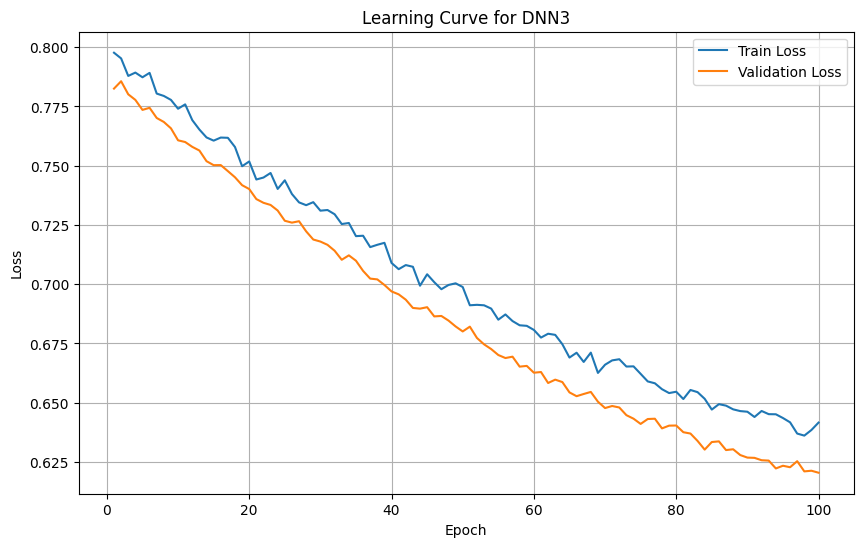

In [8]:
best_params=study.best_params
model = DNN_3(input_dim=X_train_tensor.shape[1],
              dropout1=best_params["dropout1"],
              dropout2=best_params["dropout2"],
              ).to(device)
# 最適化と訓練を実行
optimizer = optim.Adam(model.parameters(), lr=best_params["learning_rate"],weight_decay=best_params["weight_decay"])
criterion = nn.BCELoss()

num_epochs=100
train_losses = []
val_losses = []

model.train()
for epoch in range(num_epochs):
    epoch_train_loss = 0
    epoch_val_loss = 0

    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        outputs = model(X_batch).squeeze()
        loss = criterion(outputs, y_batch.squeeze())
        loss.backward()
        optimizer.step()
        epoch_train_loss += loss.item()
    avg_train_loss = epoch_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_train_loss:.4f}')

    if val_loader is not None:
        model.eval()  
        with torch.no_grad():
            for X_val, y_val in val_loader:
                X_val, y_val = X_val.to(device), y_val.to(device)
                val_outputs = model(X_val).squeeze()
                val_loss = criterion(val_outputs, y_val.squeeze())
                epoch_val_loss += val_loss.item()

        avg_val_loss = epoch_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        model.train()  

    if val_loader is not None:
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")
    else:
        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}")

plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
if val_losses:
    plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Learning Curve for DNN3')
plt.legend()
plt.grid()
plt.show()

Accuracy: 60.59%
Precision: 0.4843
Recall: 0.8991
F1 Score: 0.6296
Matthews Correlation Coefficient: 0.3464
Specificity: 0.4319


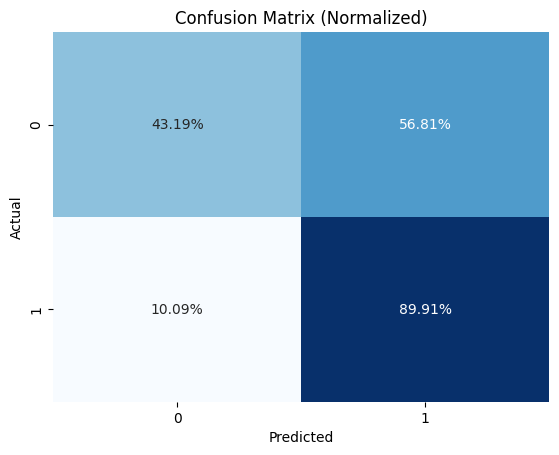

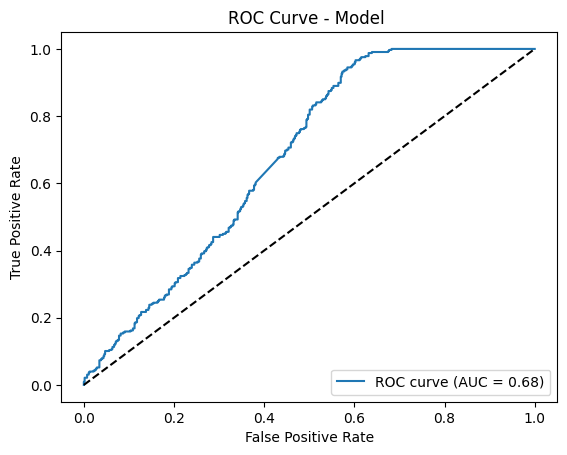

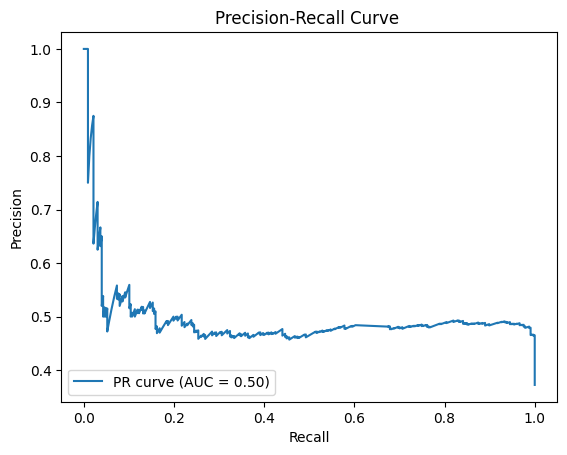

In [9]:
model.eval()
with torch.no_grad():
    X_test_tensor = X_test_tensor.to(device)
    y_test_tensor = y_test_tensor.to(device)

    # 予測と確率
    test_outputs = model(X_test_tensor).squeeze()
    predictions = (test_outputs >=0.5).float()
    y_true = y_test_tensor.cpu().numpy()
    y_pred = predictions.cpu().numpy()
    y_prob = test_outputs.cpu().numpy()

# 評価指標
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    mcc = matthews_corrcoef(y_true, y_pred)
    specificity = recall_score(y_true, y_pred, pos_label=0)  
    print(f'Accuracy: {accuracy * 100:.2f}%')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1 Score: {f1:.4f}')
    print(f'Matthews Correlation Coefficient: {mcc:.4f}')
    print(f'Specificity: {specificity:.4f}')

    # 混同行列（割合表示）
    cm = confusion_matrix(y_true, y_pred, normalize='true')
    sns.heatmap(cm, annot=True, fmt=".2%", cmap="Blues", cbar=False)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"Confusion Matrix (Normalized)")
    plt.show()

    # ROC曲線とAUC
    fpr, tpr, thresholds = roc_curve(y_true, y_prob)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--') 
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - Model ')
    plt.legend(loc="lower right")
    plt.show()

    # Precision-Recall曲線
    precision_curve, recall_curve, pr_thresholds = precision_recall_curve(y_true, y_prob)
    pr_auc = auc(recall_curve, precision_curve)
    plt.plot(recall_curve, precision_curve, label=f'PR curve (AUC = {pr_auc:.2f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve ')
    plt.legend(loc="lower left")
    plt.show()    

In [10]:
# モデルと構造を保存
torch.save(model.state_dict(), 'model_params/DNN_3.pth')



In [11]:
from torchsummary import summary
summary(model, input_size=(X_train_tensor.shape[1],))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 32]             960
       BatchNorm1d-2                   [-1, 32]              64
            Linear-3                   [-1, 16]             528
       BatchNorm1d-4                   [-1, 16]              32
           Dropout-5                   [-1, 16]               0
            Linear-6                    [-1, 8]             136
       BatchNorm1d-7                    [-1, 8]              16
           Dropout-8                    [-1, 8]               0
            Linear-9                    [-1, 4]              36
      BatchNorm1d-10                    [-1, 4]               8
           Linear-11                    [-1, 1]               5
Total params: 1,785
Trainable params: 1,785
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/back